In [1]:
import pandas as pd
import folium
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import nbformat
from datetime import datetime, date, time, timedelta
import missingno as msno



# Clean Data

In [3]:
df_kc_data =  pd.read_csv("../data/king_county_data.csv")
df_kc_data.head(2)

,Unnamed: 0,date,price,house_id,id_x,id_y,bedrooms,bathrooms,sqft_living,sqft_lot,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2014-10-13,221900.0,7129300520,1,7129300520,3.0,1.00,1180.0,5650.0,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,1,2014-12-09,538000.0,6414100192,2,6414100192,3.0,2.25,2570.0,7242.0,...,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0


In [4]:
df_kc_data.drop(["Unnamed: 0", "id_x", "id_y"], axis=1, inplace=True)
df_kc_data.columns

Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
#reorder columns
df_kc_data = df_kc_data[[ 'house_id', 'date', 'price', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15']]
df_kc_data.head(1)

,house_id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3.0,1.0,1180.0,5650.0,1.0,NaN,0.0,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0


In [6]:
df_kc_data.duplicated().value_counts()

False    21597
Name: count, dtype: int64

In [8]:
type(df_kc_data['date'][0])

str

In [9]:
df_kc_data['date'] = pd.to_datetime(df_kc_data['date'], format='%Y-%m-%d')
type(df_kc_data['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
df_kc_data['bedrooms'] = df_kc_data['bedrooms'].astype(int)
df_kc_data['bathrooms'] = df_kc_data['bathrooms'].astype(int)
df_kc_data['floors'] = df_kc_data['floors'].astype(int)
df_kc_data["condition"] = df_kc_data["condition"].astype(int)
df_kc_data['yr_renovated'] = df_kc_data['yr_renovated']/10
df_kc_data['yr_renovated'] = df_kc_data['yr_renovated'].fillna(0).astype(int) 
df_kc_data['sqft_basement'] = df_kc_data['sqft_basement'].fillna(0).astype(int) # Assuming NaN == no basement
df_kc_data['waterfront'] = df_kc_data['waterfront'].fillna(2).astype(int) # Will save NaN as "2" just in case it's useful later, as I could double check that in a map if needed
df_kc_data['view'] = df_kc_data['view'].fillna(2).astype(int) # same for now, maybe I drop them later as there are only 63 nan


df_kc_data.sample(5)

,house_id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12646,2329600040,2014-11-18,158000.0,3,1,990.0,8925.0,1,0,0,...,7,990.0,0,1962,0,98003,47.3294,-122.331,1360.0,8625.0
12018,7230400400,2014-09-26,240000.0,3,2,1220.0,17652.0,1,0,0,...,7,1220.0,0,1980,0,98059,47.4712,-122.100,1990.0,17652.0
8871,9530100555,2014-06-13,585000.0,3,1,1870.0,2807.0,1,0,0,...,7,1580.0,290,1927,0,98107,47.6674,-122.358,1640.0,4500.0
14563,8665050770,2014-06-19,505000.0,3,2,1610.0,4611.0,2,0,0,...,8,1610.0,0,1996,0,98029,47.5678,-122.004,1730.0,4461.0
516,1922059046,2014-10-29,308000.0,3,1,1980.0,39150.0,1,0,0,...,6,1580.0,400,1932,0,98030,47.3818,-122.225,1860.0,11811.0


In [12]:
df_kc_data.isna().sum()

house_id         0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [13]:
df_kc_data.head()

,house_id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1,1180.0,5650.0,1,2,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,2014-12-09,538000.0,3,2,2570.0,7242.0,2,0,0,...,7,2170.0,400,1951,199,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,2015-02-25,180000.0,2,1,770.0,10000.0,1,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,2014-12-09,604000.0,4,3,1960.0,5000.0,1,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,2015-02-18,510000.0,3,2,1680.0,8080.0,1,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [14]:
df_kc_locations = df_kc_data[["house_id", "lat", "long"]]
df_kc_locations.head()

,house_id,lat,long
0,7129300520,47.5112,-122.257
1,6414100192,47.7210,-122.319
2,5631500400,47.7379,-122.233
3,2487200875,47.5208,-122.393
4,1954400510,47.6168,-122.045


In [267]:
# Create a map centered around the average latitude and longitude
#center_lat = df_kc_locations['lat'].mean()
#center_lon = df_kc_locations['long'].mean()
#kc_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add markers to the map
#for _, row in df_kc_locations.iterrows():
 #   folium.Marker(
   #     location=[row['lat'], row['long']],
  #      popup=row['house_id']
 #   ).add_to(kc_map)

# Save the map to an HTML file
#kc_map.save("csv_map.html")

In [15]:
print(nbformat.__version__)

5.10.4


In [16]:
price_bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
price_labels = ['1', '2', '3', '4', "5", "6", "7", "8", "9", "10"]
df_kc_data['price_range'] = pd.cut(df_kc_data['price'], bins=price_bins, labels=price_labels)

<Axes: xlabel='price_range', ylabel='Count'>

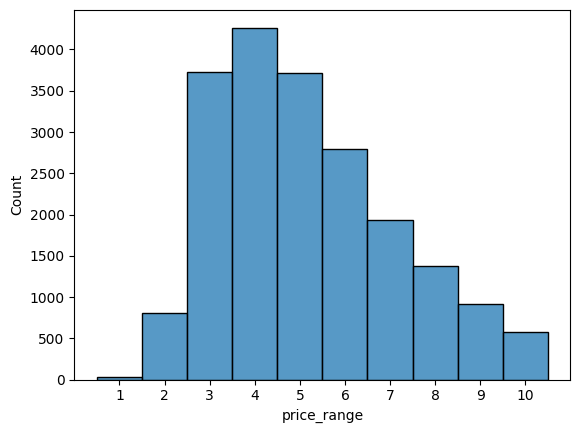

In [17]:
sns.histplot(df_kc_data["price_range"])

In [18]:
fig = px.scatter_mapbox(df_kc_data.query("price <= 200000 or price >= 800000"), 
                        lat="lat", 
                        lon="long", 
                        color= "price_range",  # Color by price range
                        hover_name= "price",  # Show price in hover info
                        color_discrete_sequence=["blue", "green", "orange", "red"], 
                        title="House Prices in King County", 
                        mapbox_style= "carto-positron", 
                        zoom=8)

# Show the plot
fig.show()

In [19]:
df_kc_data.columns

Index(['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_range'],
      dtype='object')

In [20]:
df_kc_data["zipcode"].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [21]:
poor_seattle = [98108, 98106, 98125, 98115, 98118, 98144, 98126] #from an internet research
df_kc_target = df_kc_data[df_kc_data["zipcode"].isin(poor_seattle)]
df_kc_target["zipcode"].unique()

array([98125, 98115, 98126, 98144, 98118, 98108, 98106])

<Axes: xlabel='price_range', ylabel='Count'>

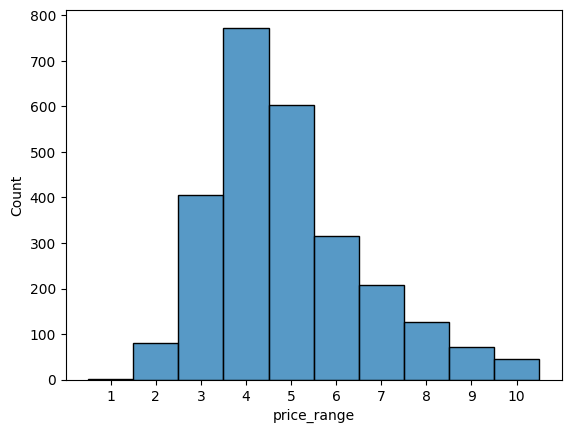

In [22]:
sns.histplot(df_kc_target["price_range"])
#interesting to see that actually poor neighbourhoods don't mean lower prices on houses

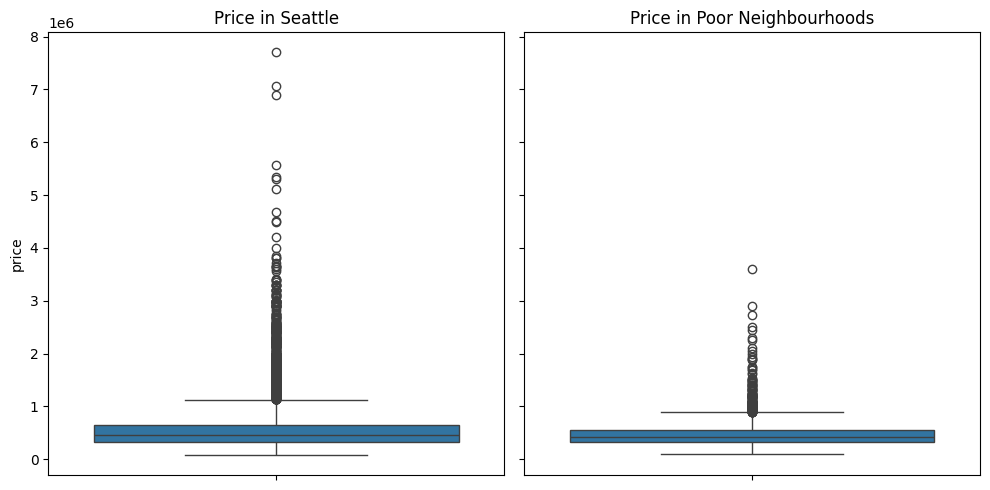

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5),sharey=True)

sns.boxplot(y=df_kc_data["price"], ax=ax[0])

sns.boxplot(y=df_kc_target["price"], ax=ax[1])

ax[0].set_title('Price in Seattle')
ax[1].set_title('Price in Poor Neighbourhoods')

plt.tight_layout() 
plt.show()

In [24]:
stats = df_kc_target["price"].describe()
Q1 = stats['25%']
Q2 = stats['50%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_whisker = max(df_kc_target.price[df_kc_target.price >= (Q1 - 1.5 * IQR)].min(), df_kc_target.price.min())
upper_whisker = min(df_kc_target.price[df_kc_target.price <= (Q3 + 1.5 * IQR)].max(), df_kc_target.price.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Lower Whisker: 90000.0
Upper Whisker: 885000.0


In [25]:
#cleaned from outliers
df_kc_target = df_kc_target.query("price <= 885000")

<Axes: xlabel='price_range', ylabel='Count'>

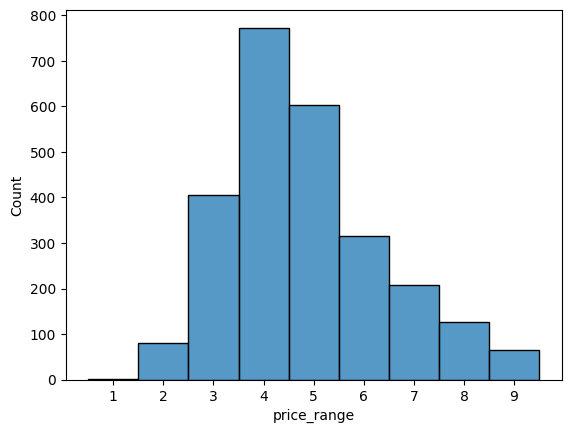

In [26]:
sns.histplot(df_kc_target["price_range"])

In [27]:
fig = px.scatter_mapbox(df_kc_target, 
                        lat="lat", 
                        lon="long", 
                        color= "price_range",  # Color by price range
                        hover_name= "price",  # Show price in hover info
                        color_discrete_sequence=["blue", "green", "orange", "red"], 
                        title="House Prices in King County", 
                        mapbox_style= "carto-positron", 
                        zoom=10)

# Show the plot
fig.show()

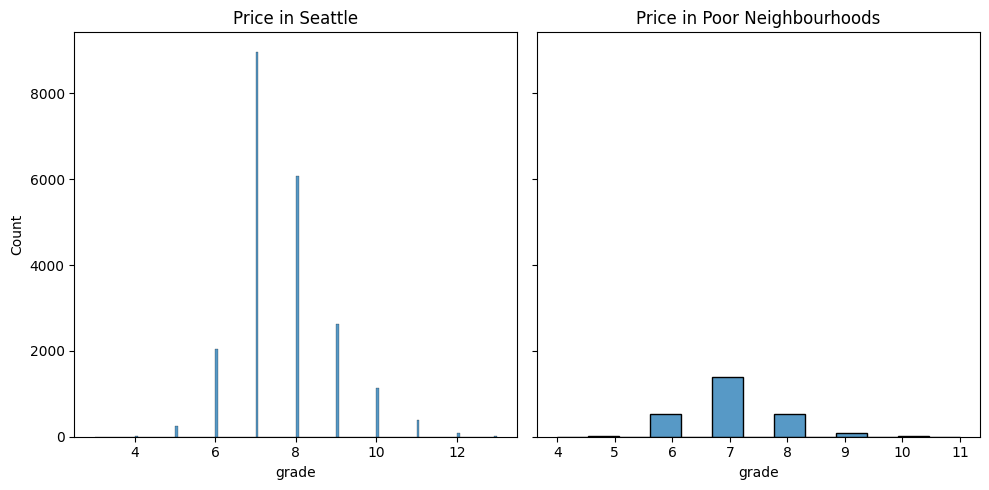

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(df_kc_data["grade"], ax=ax[0])

sns.histplot(df_kc_target["grade"], ax=ax[1])

ax[0].set_title('Price in Seattle')
ax[1].set_title('Price in Poor Neighbourhoods')

plt.tight_layout() 
plt.show()


#lower grades are more common in poor neighbourhoods

<Axes: xlabel='price', ylabel='yr_renovated'>

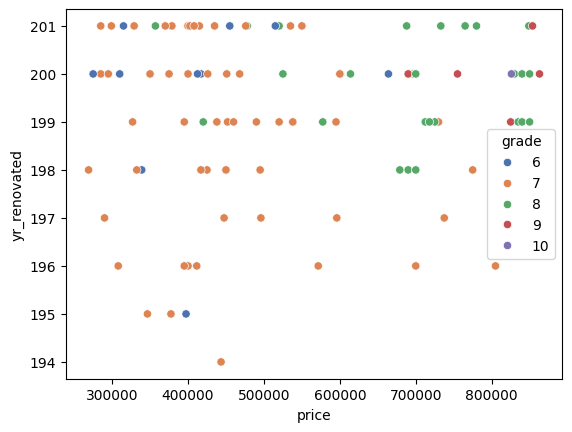

In [29]:
sns.scatterplot(df_kc_target.query("yr_renovated > 0"), x="price", y="yr_renovated", hue="grade", palette="deep" )

<Axes: xlabel='yr_built', ylabel='price'>

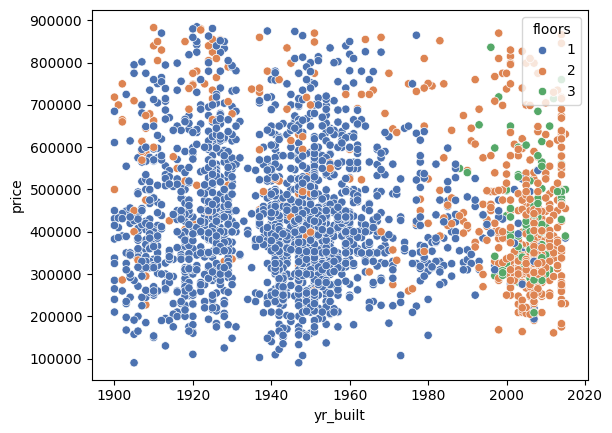

In [30]:
sns.scatterplot(df_kc_target, y="price", x="yr_built", hue="floors", palette="deep" )

<Axes: xlabel='condition', ylabel='Count'>

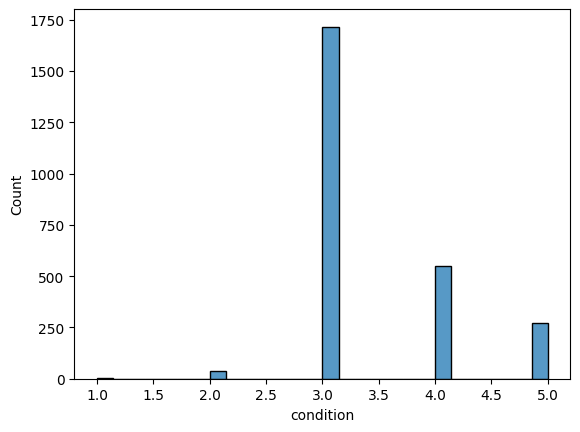

In [31]:
sns.histplot(df_kc_target["condition"])

In [32]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       2580 non-null   int64         
 1   date           2580 non-null   datetime64[ns]
 2   price          2580 non-null   float64       
 3   bedrooms       2580 non-null   int64         
 4   bathrooms      2580 non-null   int64         
 5   sqft_living    2580 non-null   float64       
 6   sqft_lot       2580 non-null   float64       
 7   floors         2580 non-null   int64         
 8   waterfront     2580 non-null   int64         
 9   view           2580 non-null   int64         
 10  condition      2580 non-null   int64         
 11  grade          2580 non-null   int64         
 12  sqft_above     2580 non-null   float64       
 13  sqft_basement  2580 non-null   int64         
 14  yr_built       2580 non-null   int64         
 15  yr_renovated   2580 non-n

In [99]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2717 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   house_id       2717 non-null   int64   
 1   date           2717 non-null   object  
 2   price          2717 non-null   float64 
 3   bedrooms       2717 non-null   float64 
 4   bathrooms      2717 non-null   float64 
 5   sqft_living    2717 non-null   float64 
 6   sqft_lot       2717 non-null   float64 
 7   floors         2717 non-null   float64 
 8   waterfront     2406 non-null   float64 
 9   view           2707 non-null   float64 
 10  condition      2717 non-null   int64   
 11  grade          2717 non-null   int64   
 12  sqft_above     2717 non-null   float64 
 13  sqft_basement  2661 non-null   float64 
 14  yr_built       2717 non-null   int64   
 15  yr_renovated   2205 non-null   float64 
 16  zipcode        2717 non-null   int64   
 17  lat            2717 non-null   float6